In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter("ignore")
from matplotlib import pyplot as plt

# Specify datafile
data_file = os.path.join('..', 'data', 'vegashrinker.csv')
# Read data
data = pd.read_csv(data_file)
# Define the input feature
feat_in_r = data.columns[[0, 6, 7, 9, 11, 12, 13]]
# Apply binning
aggmap = {a: ['mean', 'std', 'skew'] for a in feat_in_r}
aggmap['mode'] = 'first'
aggmap['pSpintor::VAX_speed'] = 'first'
binsize = 512 # 2 seconds of measurements
bins = []
for sname, sdata in data.groupby('segment'):
    sdata['bin'] = sdata.index // binsize # Build the bin numbers
    tmp = sdata.groupby('bin').agg(aggmap) # Apply the aggregation functions
    bins.append(tmp)
data_b = pd.concat(bins)

2023-10-23 07:43:47.288131: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 07:43:47.464047: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 07:43:47.464092: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 07:43:47.465290: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 07:43:47.555464: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 07:43:47.556314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Baseline Approach

## Train/Test Split

**We'll try to detect the component state by learning an autoencoder**

* We'll train a model on the earlier data
* ...And then use the reconstruction error as a proxy for component wear

**We start as usual by splitting the training and test set**

In [2]:
tr_sep = int(0.5 * len(data_b))
data_b_tr = data_b.iloc[:tr_sep]
data_b_ts = data_b.iloc[tr_sep:]

...And then by standardizing our data

In [3]:
scaler = StandardScaler()
data_b_s_tr = scaler.fit_transform(data_b_tr)
data_b_s_ts = scaler.transform(data_b_ts)
data_b_s = pd.DataFrame(columns=data_b.columns, data=np.vstack([data_b_s_tr, data_b_s_ts]))

## Training and Autoencoder

**Now we can build and train the autoencoder**

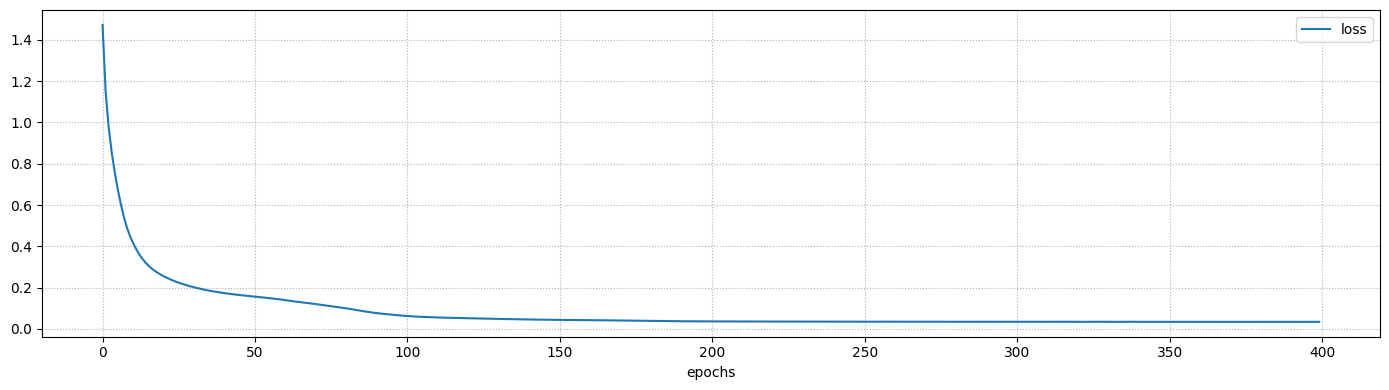

Final loss: 0.0347 (training)


In [4]:
nn = util.build_nn_model(input_shape=len(data_b.columns), output_shape=len(data_b.columns),
                         hidden=[len(data_b.columns)//2])
history = util.train_nn_model(nn, data_b_s_tr, data_b_s_tr, loss='mse', validation_split=0.0,
                              batch_size=32, epochs=400)
util.plot_training_history(history, figsize=figsize)

* We need many epochs to compensate for the small number of samples

## Evaluation

**Let's check the reconstruction error**

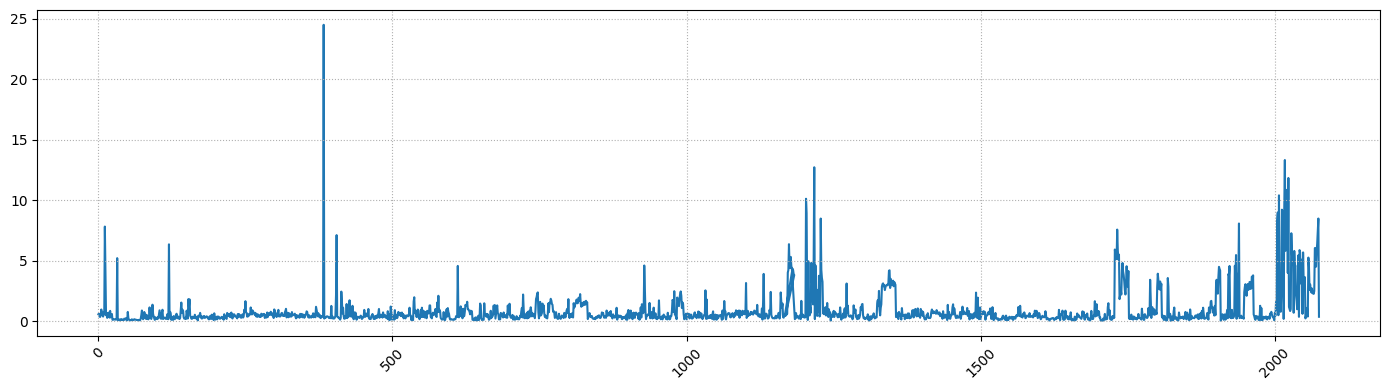

In [5]:
pred = nn.predict(data_b_s, verbose=0)
se = (data_b_s - pred)**2
sse = pd.Series(index=data_b.index, data=np.sum(se, axis=1))
util.plot_series(sse, figsize=figsize)

* Since we have a single run, we will limit ourselves to a visual inspection
* ...And the signal does not look very clear

## Evaluation

**We can gain more information by checking the individual errors**

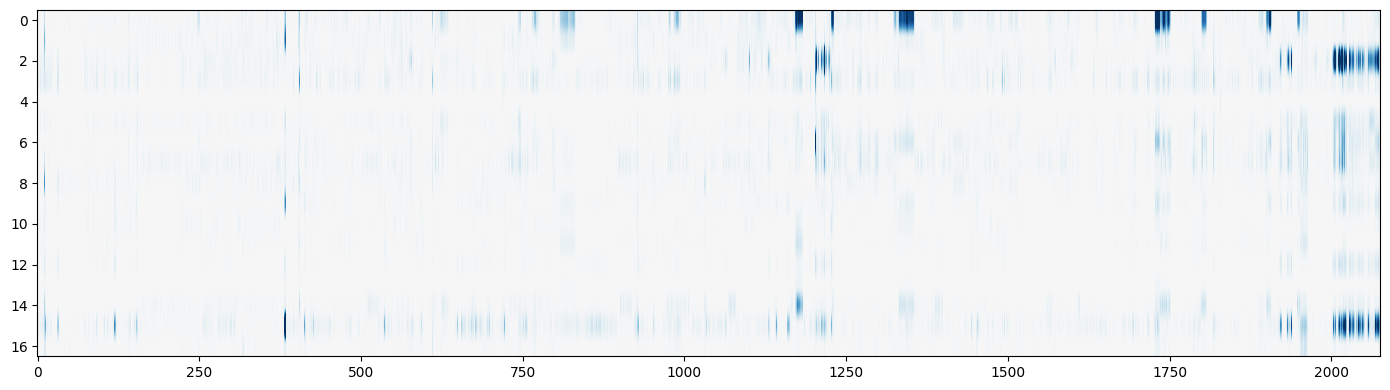

In [6]:
util.plot_dataframe(se, figsize=figsize)

* Reconstruction errors are large for different features over time

<div class=big>Do you think we can improve these results? How?</div>

# Altering the Training Distribution

## Distribution Discrepancy

**A major problem is related to the distribution balance**

The modes of operation are _not used equally often_

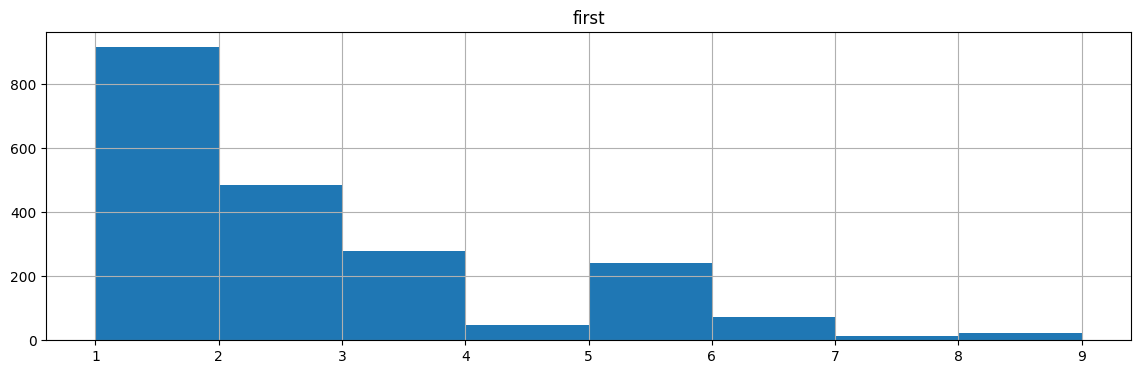

In [8]:
data_b['mode'].hist(figsize=figsize, bins=np.arange(1, 10));

* Moreover, the mode of operation is a _controlled variable_
* ...Hence its distribution might change a lot based on the workload 

## Distribution Discrepancy

**In fact, there is a difference between the training and test distribution**

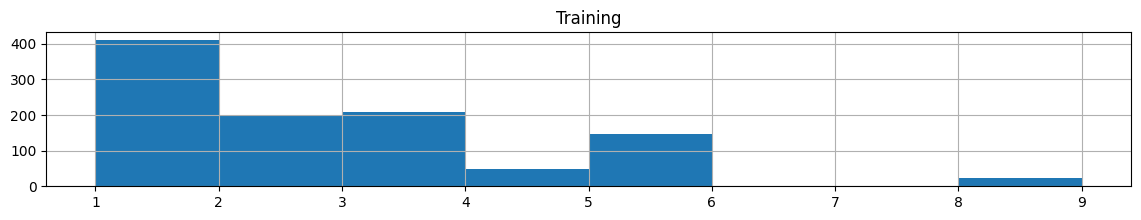

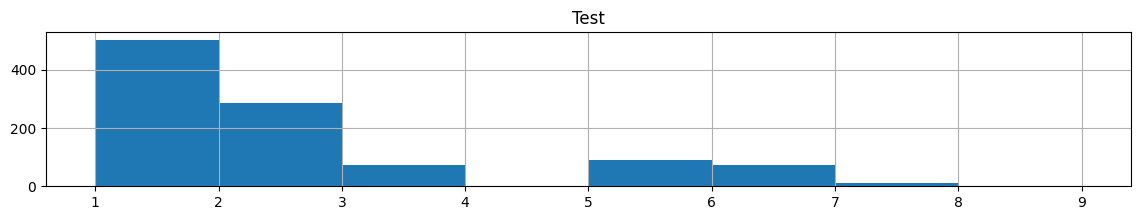

In [9]:
data_b_tr['mode'].hist(figsize=(figsize[0], figsize[1]/2), bins=np.arange(1, 10)); plt.title('Training');
data_b_ts['mode'].hist(figsize=(figsize[0], figsize[1]/2), bins=np.arange(1, 10)); plt.title('Test');

## Maximum Likelihood

**This matters because we are _training for maximum likelihood_**

...Ideally we would like to solve:

$$
\mathop{\text{argmax}}_{\theta} \mathbb{E}_{x, y \sim P}\left[ \prod_{i=1}^m f_\theta(y_i \mid x_i) \right]
$$

* $P$ represents the real (joint) distribution
* $f_\theta(\cdot \mid \cdot)$ is our estimated probability, with parameter vector $\theta$
* I.e. an estimator for a conditional distribution
* We distinguish $x$ (input) and $y$ (output) to cover generic supervised learning
* ...Even if for an autoencoder they are the same

## ...And Empirical Risk

**...But in practive we don't have access to the full distribution**

So usually we employ a Monte-Carlo approximation:

$$
\mathop{\text{argmax}}_{\theta} \prod_{i=1}^m f_\theta(y_i \mid x_i)
$$

* Typically, we consider _a single sample_ $x, y$ (i.e. the _training set_)
* The resulting objective (i.e. the big product) is sometimes called _empirical risk_

**Problems arise when _our sample is biased_.** E.g. because:

* We can collect data only under certain circumstances
* The dataset is the result of a selection process
* ...Or perhaps due to pure sampling noise

## Handling Sampling Noise

**So, let's recap**

* Our issue is that the training sample is biased
* ...So that it is _not representative_ of the true distribution

> **How can we deal with this problem?**

* A possible solution would be to _alter the training distribution_
* ...So that it _matches more closely_ the test distribution

**...And this is actually something we can do!**

* E.g. we can use data augmentation, or subsampling
* ...Or we can use _sample weights_

## Virtual Alterations to the Training Distribution

**Let our training set consist of $\{(x_1, y_1), (x_2, y_2)\}$**

The corresponding optimization problem would be:

$$
\mathop{\text{argmax}}_{\theta} f_\theta(y_1 \mid x_1) f_\theta(y_2 \mid x_2)
$$

If sample \#2 occurred twice in the training data, we would have

$$
\mathop{\text{argmax}}_{\theta} f_\theta(y_1 \mid x_1) f_\theta(y_2 \mid x_2)^2
$$

Normalizing over the number of samples does not change the minima:

$$
\mathop{\text{argmax}}_{\theta} f_\theta(y_1 \mid x_1)^{\frac{1}{3}} f_\theta(y_2 \mid x_2)^{\frac{2}{3}}
$$

## Virtual Alterations to the Training Distribution

**Let's generalize these considerations:**

A general training problem based on Empirical Risk Minimization is the form:

$$
\mathop{\text{argmax}}_{\theta} \prod_{i=1}^m f_\theta(y_i \mid x_i)
$$

We can virtually _alter the training distribution_ via exponents:

$$
\mathop{\text{argmax}}_{\theta} \prod_{i=1}^m f_\theta(y_i \mid x_i)^{w_i}
$$

* We can do this to make the training distribution _more representative_
* E.g. when we expect a discrepancy between the trainign and test distribution

## Virtual Distribution and Sample Weights

**When we switch to log-likelihood minimization**

...The exponents become _sample weights_

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m w_i \log f_\theta(y_i \mid x_i)
$$

We can _always_ view the weights as the ratio of two probabilities:

$$
w_i = \frac{p^*_i}{p_i}
$$

* $p_i$ is the sampling bias that we want to _cancel_
* $p^*_i$ is the distribution we wish to _emulate_

**This approach is known as _importance sampling_**

## Canceling Sampling Bias in Our Problem

**Let's apply the approach to our skinwrapper example**

We know there's an _unwanted sampling bias_ for some modes of operation

* Let $m(x_i)$ be the mode of operation for the $i$-th sample
* Then we can estimate $p_i$ as a frequency of occurrence:

$$
p_i = \frac{1}{n} \left|\{k : m(x_k) = m(x_i), k = 1..n\}\right|
$$

We _don't want_ out anomaly detector to be sensitive to the mode

* So we can assumption a uniform distribution for $p^*_i$:

$$
p_i = \frac{1}{n}
$$

## Canceling Sampling Bias in Our Problem

**By combining the two we get:**

$$
w_i = \frac{1}{\left|\{k : m(x_k) = m(x_i), k = 1..n\}\right|}
$$

* I.e. the weight is just the inverse of the corresponding mode count

**We can compute the weigths by first obtaining inverse counts for all modes**

In [23]:
vcounts = data_b_tr['mode', 'first'].value_counts()
mode_weight = 1 / vcounts

Then by associating the respective value to every sample:

In [24]:
sample_weight = mode_weight[data_b_tr['mode', 'first']]

## Training with Sample Weights

**Now we can pass training weights to the training algorithm**

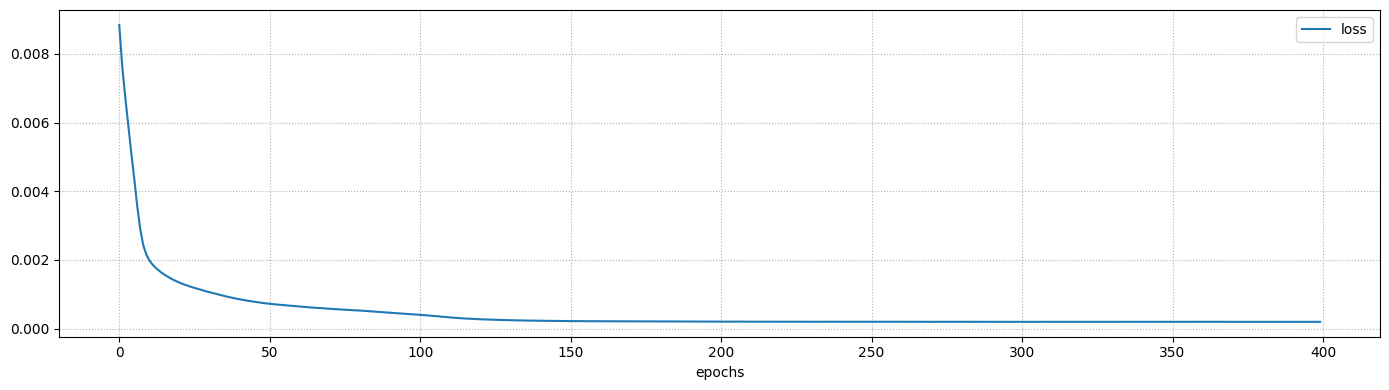

Final loss: 0.0002 (training)


In [25]:
nn2 = util.build_nn_model(input_shape=len(data_b.columns), output_shape=len(data_b.columns), hidden=[len(data_b.columns)//2])
history = util.train_nn_model(nn2, data_b_s_tr, data_b_s_tr, loss='mse', validation_split=0.0, batch_size=32, epochs=400, sample_weight=sample_weight)
util.plot_training_history(history, figsize=figsize)

## Evaluation

**Let's check the new reconstruction error**

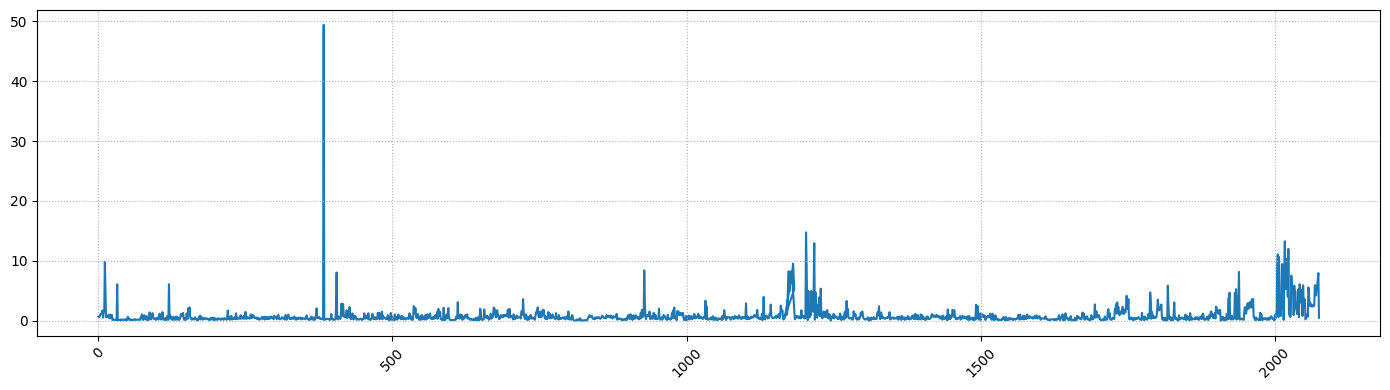

In [26]:
pred2 = nn2.predict(data_b_s, verbose=0)
se2 = (data_b_s - pred2)**2
sse2 = pd.Series(index=data_b.index, data=np.sum(se2, axis=1))
util.plot_series(sse2, figsize=figsize)

At a first glance, the change is not dramatic

## Evaluation

**...But the individual error components are very different**

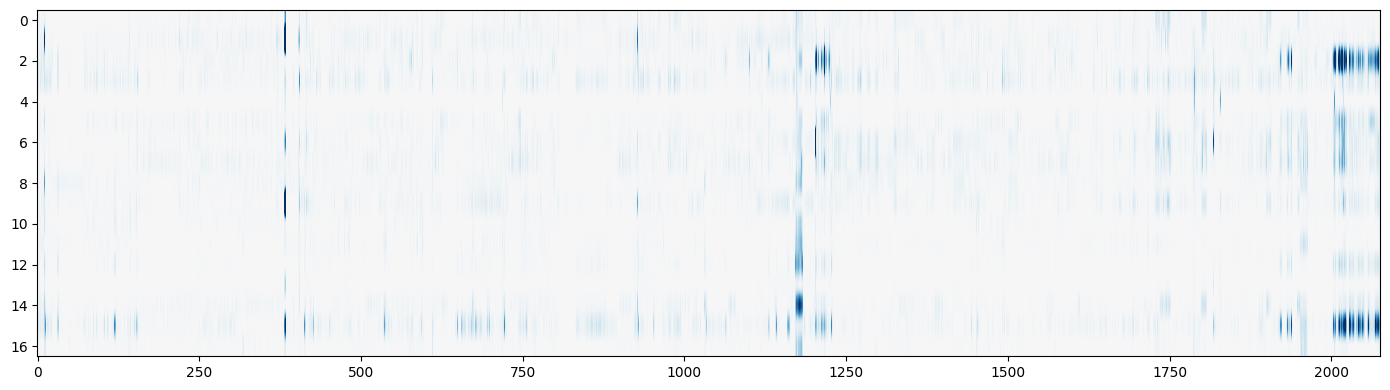

In [27]:
util.plot_dataframe(se2, figsize=figsize)

* Suspected anomalies in the middle sequence have almost disappeared
* ...And there is a much clearer plateau at the end of the signal

# Applications of Importance Sampling

<div class=big>
    <small>Despite its simplicity, importance sampling has many applications</small><br>
Can you identify a few?
</div>

## Class Rebalancing

**The usual _class rebalancing trick_ is a subcase of importance sampling**

In this situation, we assume that some classes are over/under sampled

* Therefore, we estimate $p_i$ using the class frequency
* We make a neutral (uniform) assumption on $p^*_i$
* ...And we define the sample weights for $(x_i, y_i)$ as:

$$
w_i = \frac{1}{n} \frac{n}{\left|\{k : y_k = y_i, k = 1..n\}\right|}
$$

**Watch out during evaluation!**

* Evaluating via (e.g.) accuracy on the unmodified test set _might be a mistake_
* ...Since the weights alter the training distribution

Use a _cost model_ instead, or just a confusion matrix

## Removing Sampling Bias based on Continuous Attribute

**The $p_i$ and $p^*_i$ values can be probability _densities_**

...Meaning we can remove sampling bias over _continuous attributes_, e.g.:

* Continuous control variables (position, speed, etc.) in industrial machines
* Income or age in socio-economic applications
* Number of reviews in online rating systems

**In this case:**

We can first apply any _density estimation_ approach

* The discrete attribute/class case is the same (we just use a histogram)

Then, it's a good idea to apply some _clipping_, i.e. $p_i = \max(l, \min(u, f(x_i, y_i)))$

* Densities can be very high/low, causing numerical instability

## Removing Sampling Bias due to External Attributes

**It is possible to remove sampling bias due to an "external" process**

Consider an organ transplant program

* Candidate recipients are described by attribute $x_i$ and wait in a queue
* ...from which they may be selected ($y_i = 1$) or not ($y_i = 0$) for surgery
* ...Surgey may then have a positive ($z_i = 1$) or negative ($z_i = 0$) outcome

**Say we want to improve the outcome estimation using ML**

...And possibly use to adjust the selection criterion

* The historical data will be _subject to bias_ due to existing criteria
* ...But if we can estimate the _current selection proabability $P(Y \mid X)$_
* ...We can can use it as $p_i$ for mitigating the bias!

Any classifier with probabilistic output can be used on this purpose

## Sample-specific Variance

**With an _MSE loss_, sample weights have also an alternative interpretation**

In this case we have proved the training problem is equivalent to:

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m \log k \exp\left(-\frac{1}{2}(y_i - h_\theta(x_i))^2\right)
$$

* We have simply replaced the generic PDF with a Normal one
* We have $k = 1/\sqrt{2\pi}$ to simplify the notation

**Let's now introduce sample weights, in the form as $1/\hat{\sigma}_i^2$**

By doing so we get:

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m \frac{1}{\sigma_i^2} \log k \exp\left(-\frac{1}{2}(y_i - h_\theta(x_i))^2\right)
$$


## Sample-specific Variance

**Which can be rewritten as:**

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m \log k \exp\left(-\frac{1}{2}\left(\frac{y_i - h_\theta(x_i)}{\sigma_i}\right)^2\right)
$$

* This means that sample weights with an MSE loss
* ...Can be interpreted as _inverse sample variances_

**This gives us a way to account for _non-uniform measurement errors_**

* If we know that there is a measurment error with stdev $\sigma_i$ on example $i$
* ...We can account for that by using $1/\sigma_i^2$ as a weight

The result is analogous to using a separate variance model

## Stochastic Differentiation in Reinforcement Learning

**Importance sampling finds applications also in _Reinforcement Learning_**

While the goal of _statistical ML_ is usually maximize a likelihood, e.g.:

$$
\mathop{\text{argmax}}_{\theta} \mathbb{E}_{x, y \sim P} \left[ f_\theta(y \mid x) \right]
$$


...The goal of RL is to _learn how to optimize_ a reward, e.g.:

$$
\mathop{\text{argmax}}_{\theta} \mathbb{E}_{x \sim P} \left[ f(x, \pi_\theta(x)) \right]
$$

**Where the presented formulation focuses on _a single step_ (for simplicity)**

* $x$ represents an observable _state_
* $\pi_\theta: x \mapsto a$ is a parameterized policy outputing an _action_
* $f: x, a \mapsto r$ is a _reward function_

## Stochastic Differentiation in Reinforcement Learning

**In tipical RL settings, the reward function is _non-differentiable_**

* In [AlphaGo Zero](https://www.deepmind.com/blog/alphago-zero-starting-from-scratch), the ultimate reward is winning a game of Go
* For [OpenAI Five](https://en.wikipedia.org/wiki/OpenAI_Five) the goal is winning a game of Dota 2
* In [this research](https://arxiv.org/pdf/1812.11103.pdf) the goal is for a robot not to fall

**If we still want to use a gradient method, we need to overcome this issue**

* One way is approximating $f$ via a _differentiable critic_ (e.g. a NN)
* ...Another is using a _stochastic policy_

**In the latter case, $\pi_\theta$ defines a probability distribution $\pi_\theta(a \mid x)$**

* Given a state $x$, we might obtain different actions $a$
* ...Usually according to a Normal distribution (with fixed $\sigma$)

## Stochastic Differentiation in Reinforcement Learning

**With a stochastic policy, the training problem becomes:**

$$
\mathop{\text{argmax}}_{\theta} \mathbb{E}_{x \sim P, a \sim \pi_\theta(a \mid x)} \left[ f(x, a) \right]
$$

* The semantic is not the same as the original, but the goal is similar
* The problem contains now a _double expectation_

**We could try to use a Monte Carlo approach with both**

* There are well established techniques for sampling $x$
* ...And we could sample actions $\{a_k\}_{k=1}^m$ directly from $\pi_\theta(a \mid x)$, obtaining:

$$
\mathbb{E}_{a \sim \pi_\theta(a \mid x)} \left[ f(x, a) \right] \simeq \frac{1}{m} \sum_{k=1}^m f(x, a_k)
$$

...But unfortunately this expression is again non-differentiable

## Stochastic Differentiation in Reinforcement Learning

**It is possible to circumvent the issue via importance sampling**

We sample the actions _uniformly at random_, but then we alter their distribution

* All $p_i$ are identical, due to the uniform assumption
* The $p^*_i$ are given by the policy itself, leading to:

$$
\mathbb{E}_{a \sim \pi_\theta(a \mid x)} \left[ f(x, a) \right] \simeq \frac{1}{m} \sum_{k=1}^m \pi_\theta(a_k \mid x) f(x, a_k)
$$

* While the $f(x, a_k)$ is still just a constant
* ...The probability $\pi_\theta(a_k \mid x)$ is now _differentiable in $\theta$_

**Intuitively: we train to increase the probability of good actions**

## Stochastic Differentiation in Reinforcement Learning

**This differentiation trick via importance sampling is a bit crude**

* Uniform sampling might generate actions with very low probability
* ...Leading to noisy estimates and numerical issues

In practice, it's not a good idea to use it direcly

**...But it is the basis for some famous RL methods!**

* It is used to derive the original REINFORCE algorithm
* It is central to the TRPO method
* ...And to the state-of-the-art Proximal Policy Optimization method